In [2]:
!nvidia-smi

Mon Feb  7 07:37:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_folders = sorted(glob('/content/drive/MyDrive/Brain _Tumor_Detection/*'))

In [6]:
len(train_folders)

4

#Dataset Exploration

In [7]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA)
  return img

In [8]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [9]:
def show_Tumor(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(16, 16))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


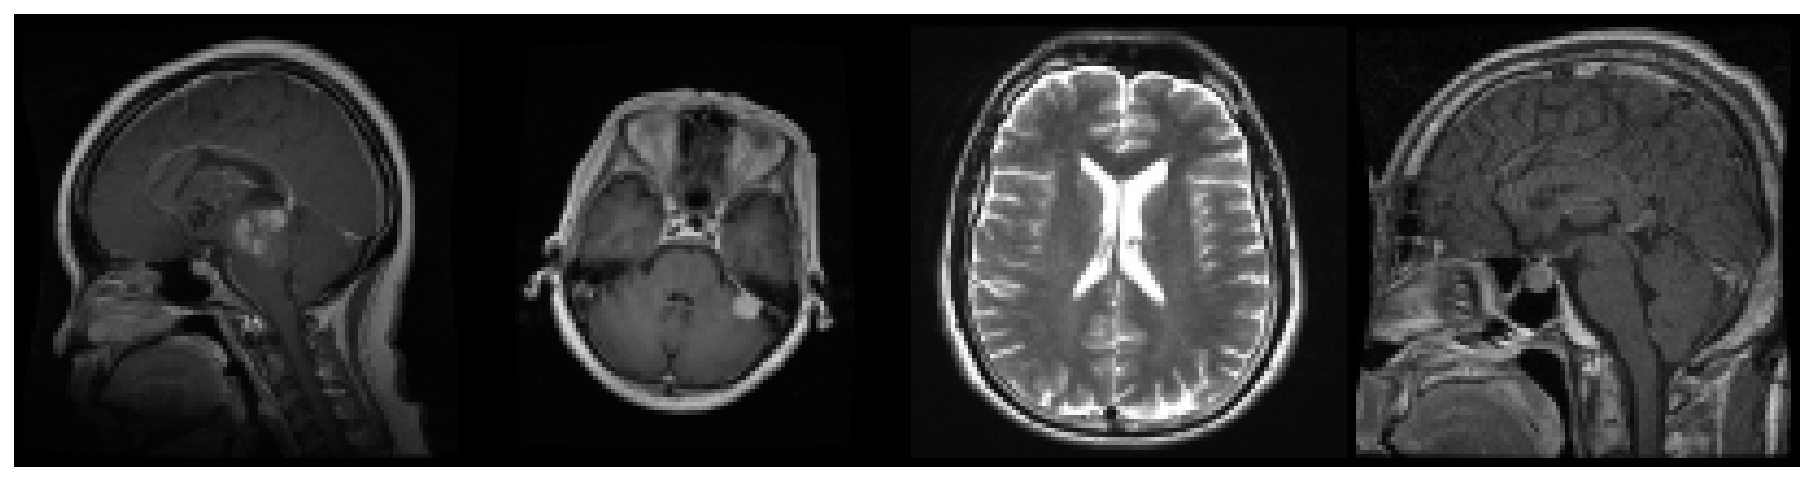

In [10]:
sample_images = [np.random.choice(glob(f'{tf}/*.jpg')) for tf in train_folders]
show_Tumor(sample_images)

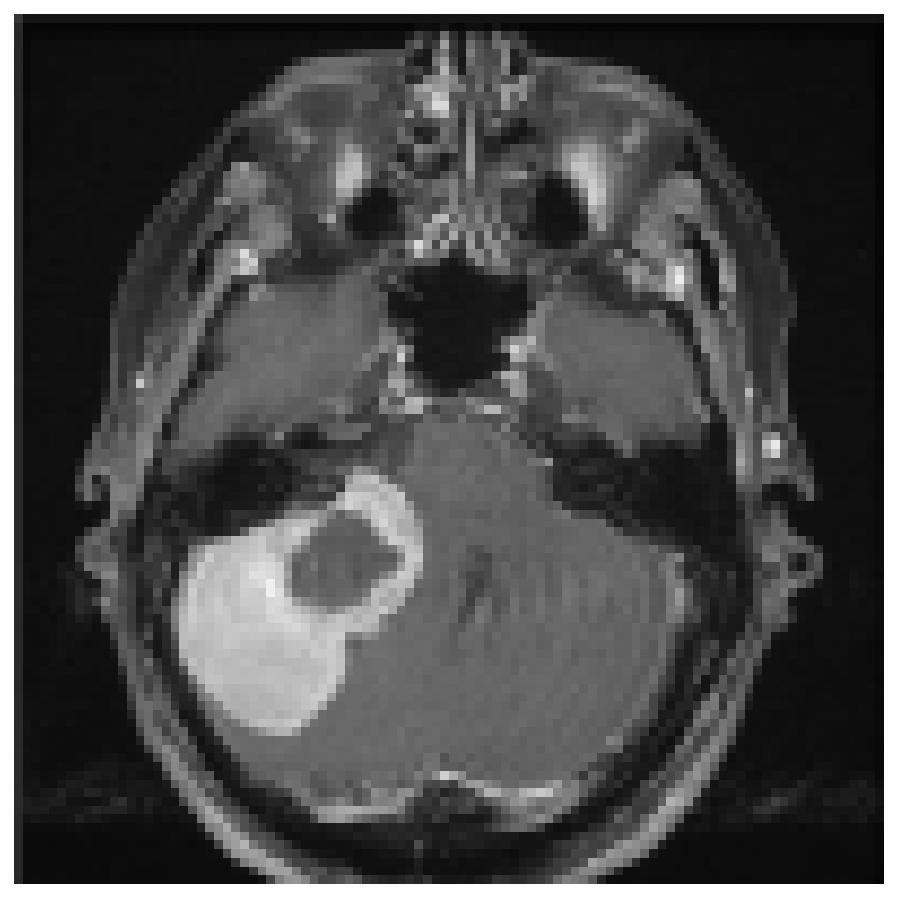

In [11]:
img_path = glob(f'{train_folders[1]}/*.jpg')[1]

show_image(img_path)

#Building Dataset

In [12]:
class_names = ['Glioma_Tumor', 'Meningioma_Tumor', 'Pituitary_Tumor']
class_indices=[0, 1, 3]

In [13]:
!rm -rf data
DATA_DIR = Path('/content/drive/MyDrive/Resultant_Brain_Tumor')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [14]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.jpg'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Glioma_Tumor: 926
Meningioma_Tumor: 937
Pituitary_Tumor: 901


In [15]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.225, 0.225, 0.225]

transforms = {'train': T.Compose([
  #T.RandomResizedCrop(size=256),
  T.Resize(size=(225, 225)),
  T.RandomRotation(degrees=20),
  #T.RandomHorizontalFlip(),
  #T.RandomVerticalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=(225, 225)),
  #T.RandomRotation(degrees=15),
  #T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=(225, 225)),
  #T.RandomRotation(degrees=15),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [16]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=0) 
  for d in DATASETS
}

In [17]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 278, 'train': 2209, 'val': 277}

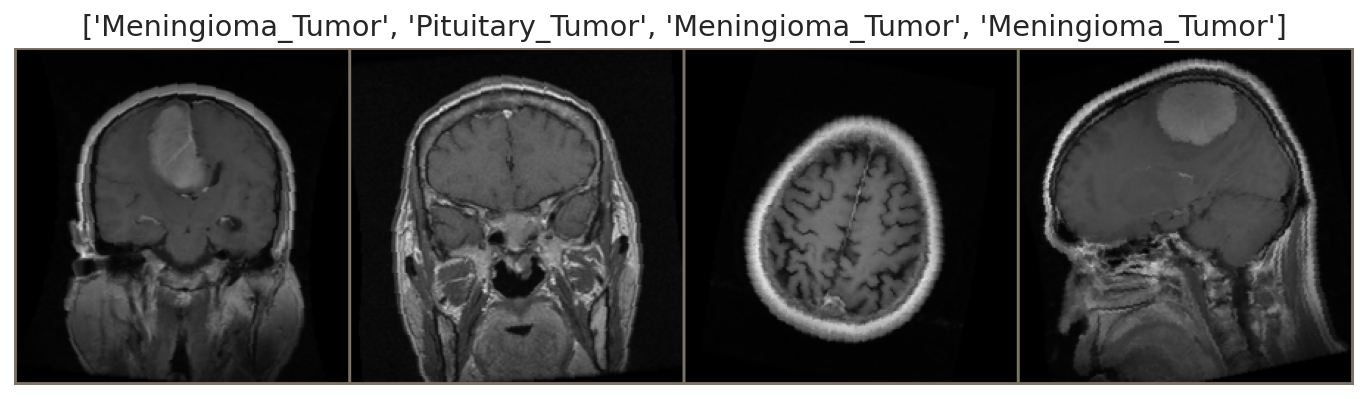

In [18]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
class model(nn.Module):
  def __init__(self, num_classes= 3):
   super(model, self).__init__()
   self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
   self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
   self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =1),
        #nn.Dropout(p=0.5)
    )
   self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=7, stride = 1, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2),
        #nn.Dropout(p=0.25)
    )
   self.layer5 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
   self.layer6 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
   self.fc1 = nn.Linear(4*4*128, 256) 
   self.fc2 = nn.Linear(256, 128)
   #self.fc3 = nn.Linear(64, 32)
   #self.fc4 = nn.Linear(32, 16)   
   self.fc5 = nn.Linear(128, num_classes) 

   self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Softmax()           

    )
   
   

    
  def forward(self, x):
    #print(x.shape)
    out = self.layer1(x)
    #print(out.shape)
    out = self.layer2(out)
    #print(out.shape) 
    out = self.layer3(out)
    #print(out.shape)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)
    #print(out.shape)
    out= out.reshape(out.size(0), -1)
    out = self.fc1(out)  
    out = self.fc2(out)  
    #out = self.fc3(out)  
    #out = self.fc4(out)  
    out = self.fc5(out)  
    out = self.classifier(out)
    #print(out.shape) 
     
    return out 

In [20]:
model = model().to(device)

#Training

In [21]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=80):

      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.6)
      scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
      loss_fn = nn.CrossEntropyLoss().to(device)
      history = defaultdict(list)
      best_accuracy = 0

      for epoch in range(n_epochs):

        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
          model,
          data_loaders['train'],    
          loss_fn, 
          optimizer, 
          device, 
          scheduler, 
          dataset_sizes['train']
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
          model,
          data_loaders['val'],
          loss_fn,
          device,
          dataset_sizes['val']
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
          torch.save(model.state_dict(), 'best_model_state.bin')
          best_accuracy = val_acc

      print(f'Best val accuracy: {best_accuracy}')
      
      model.load_state_dict(torch.load('best_model_state.bin'))

      return model, history

In [24]:
model, history = train_model(model, data_loaders, dataset_sizes, device)

Epoch 1/80
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train loss 0.8844719493583141 accuracy 0.6582163875056587
Val   loss 0.8337279438972474 accuracy 0.700361010830325

Epoch 2/80
----------
Train loss 0.8066992747848332 accuracy 0.740153915799004
Val   loss 0.8141356408596039 accuracy 0.7220216606498195

Epoch 3/80
----------
Train loss 0.7755477636459723 accuracy 0.7695789950203712
Val   loss 0.7327040765966688 accuracy 0.8158844765342961

Epoch 4/80
----------
Train loss 0.7551762158788781 accuracy 0.7935717519239475
Val   loss 0.780459554706301 accuracy 0.7653429602888087

Epoch 5/80
----------
Train loss 0.7404089655194964 accuracy 0.8107741059302852
Val   loss 0.7211578377655574 accuracy 0.8158844765342961

Epoch 6/80
----------
Train loss 0.7342755852728597 accuracy 0.8125848800362154
Val   loss 0.7218246638774872 accuracy 0.8194945848375451

Epoch 7/80
----------
Train loss 0.7493517203744885 accuracy 0.797193300135808
Val   loss 0.716096511057445 accuracy 0.8375451263537906

Epoch 8/80
----------
Train loss 0.6786280900617189 ac

In [25]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 2.0])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

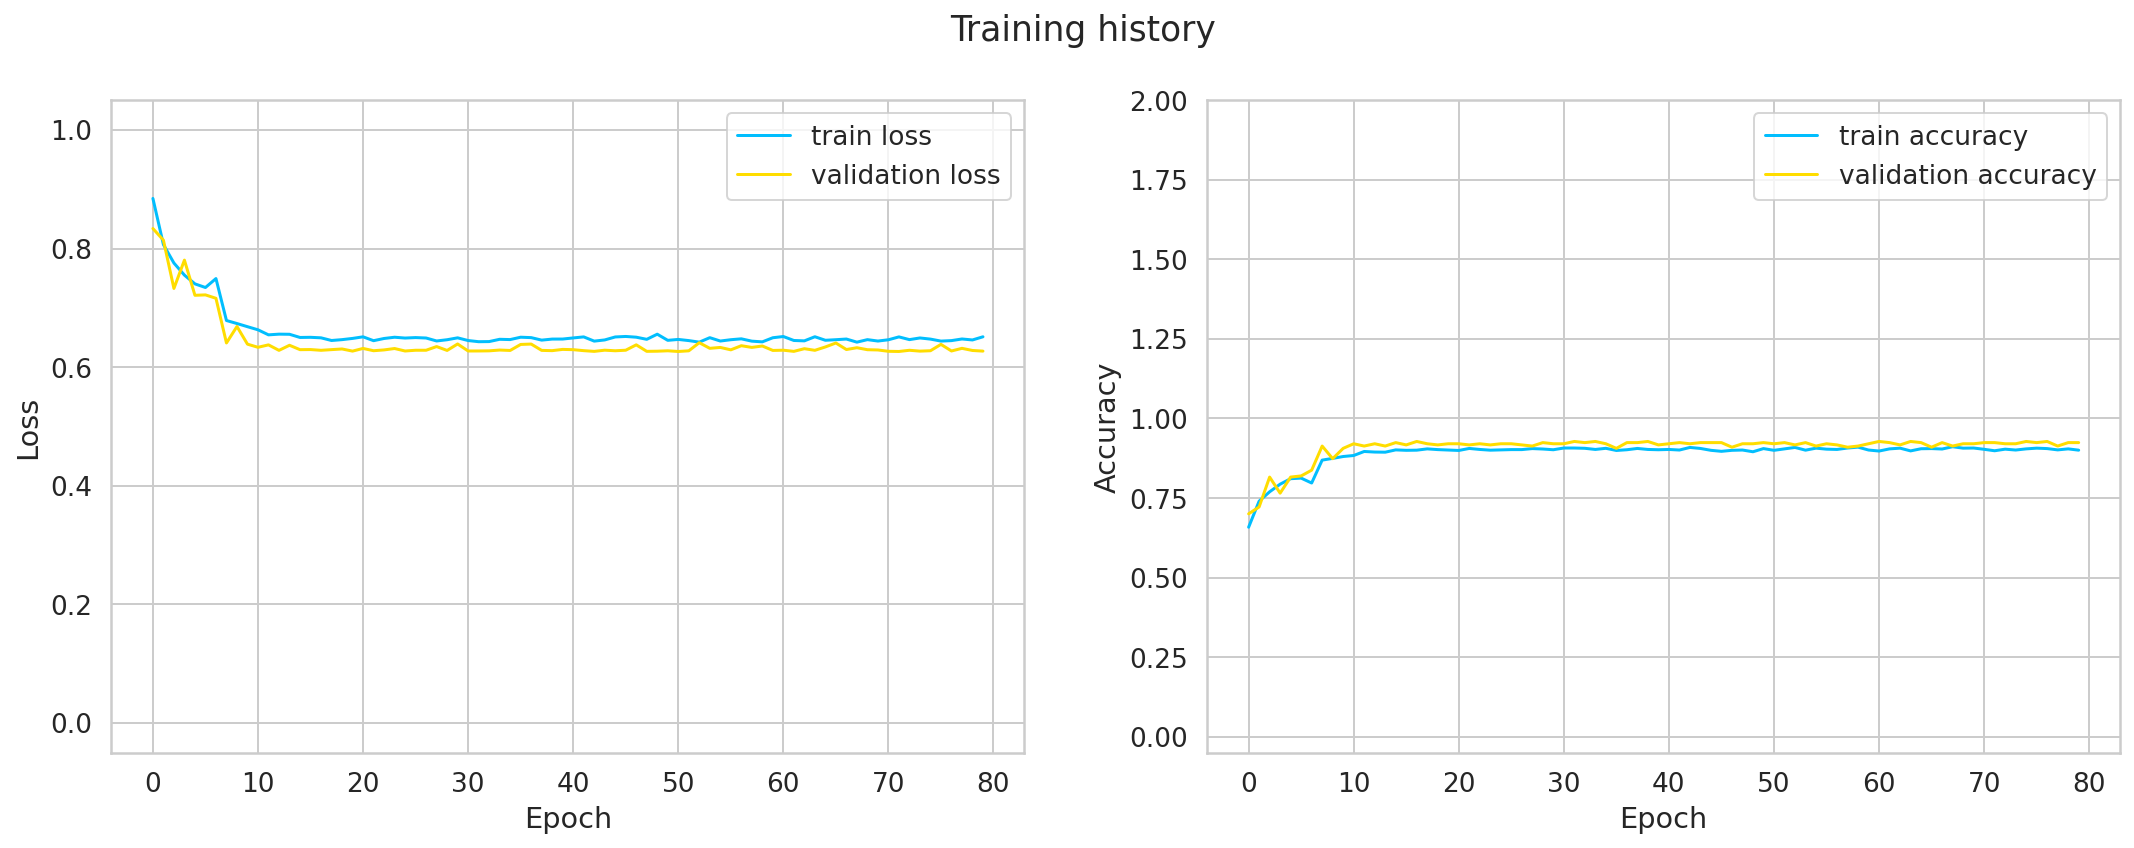

In [26]:
plot_training_history(history)

#Evaluation

In [27]:
def show_predictions(model, class_names, n_images=8):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


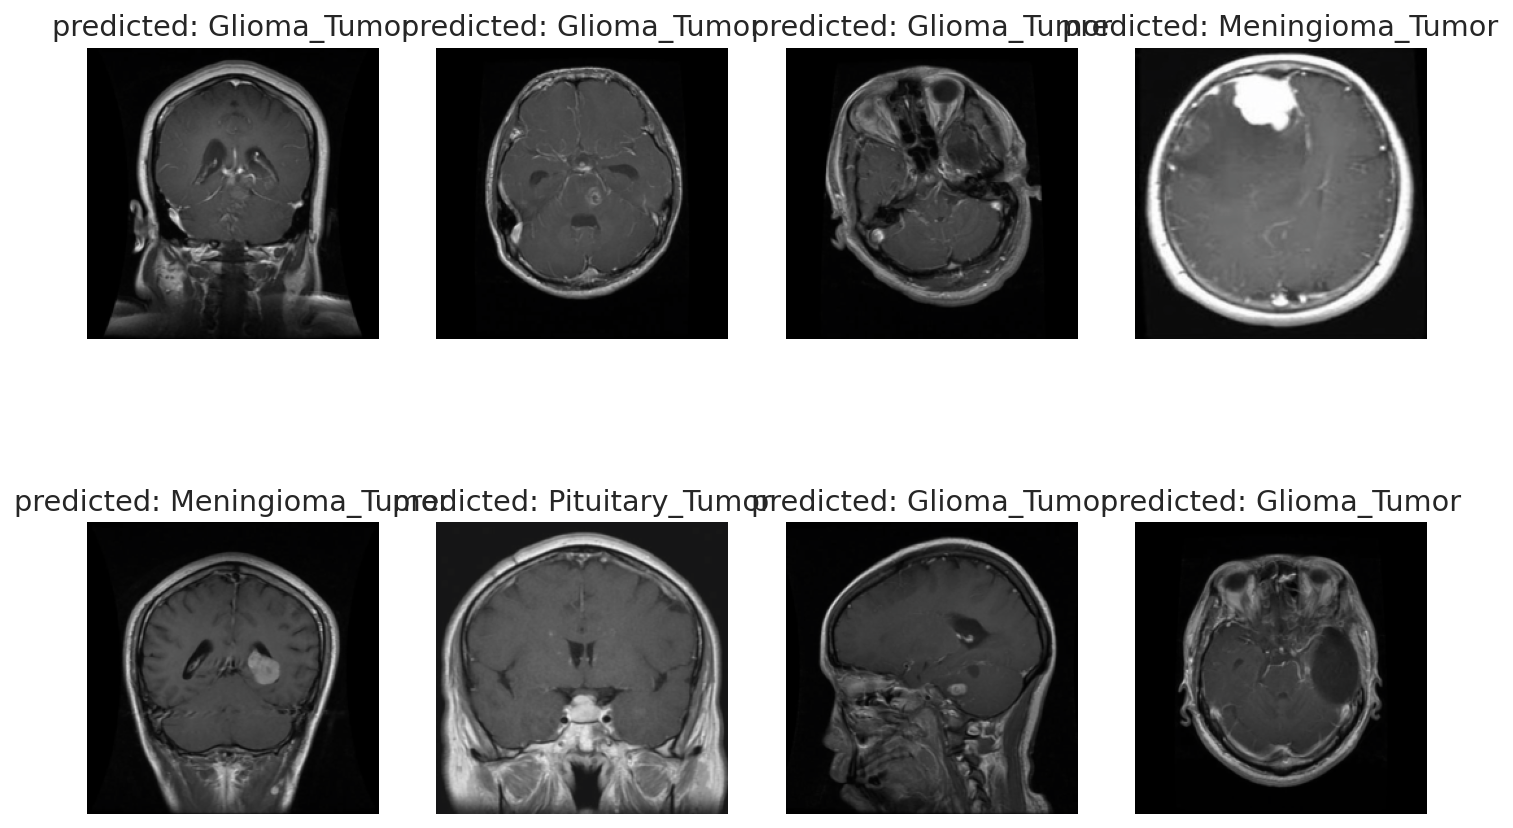

In [28]:
show_predictions(model, class_names, n_images=8)

In [29]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [30]:
y_pred, y_true = get_predictions(model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [31]:
print(classification_report(y_true, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

    Glioma_Tumor       0.99      0.85      0.91        93
Meningioma_Tumor       0.85      0.93      0.89        94
 Pituitary_Tumor       0.93      0.98      0.95        91

        accuracy                           0.92       278
       macro avg       0.92      0.92      0.92       278
    weighted avg       0.92      0.92      0.92       278



In [32]:
import torch
mae_loss = torch.nn.L1Loss()
input = torch.Tensor.float(y_pred)
target = torch.Tensor.float(y_true)
output = mae_loss(input, target)
print('MAE:',output)

MAE: tensor(0.0863)


In [33]:
input = torch.Tensor.float(y_pred)
target = torch.Tensor.float(y_true)
mse_loss = nn.MSELoss()
output = mse_loss(input, target)

print('MSE- output -: ', output)

MSE- output -:  tensor(0.0935)


In [34]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

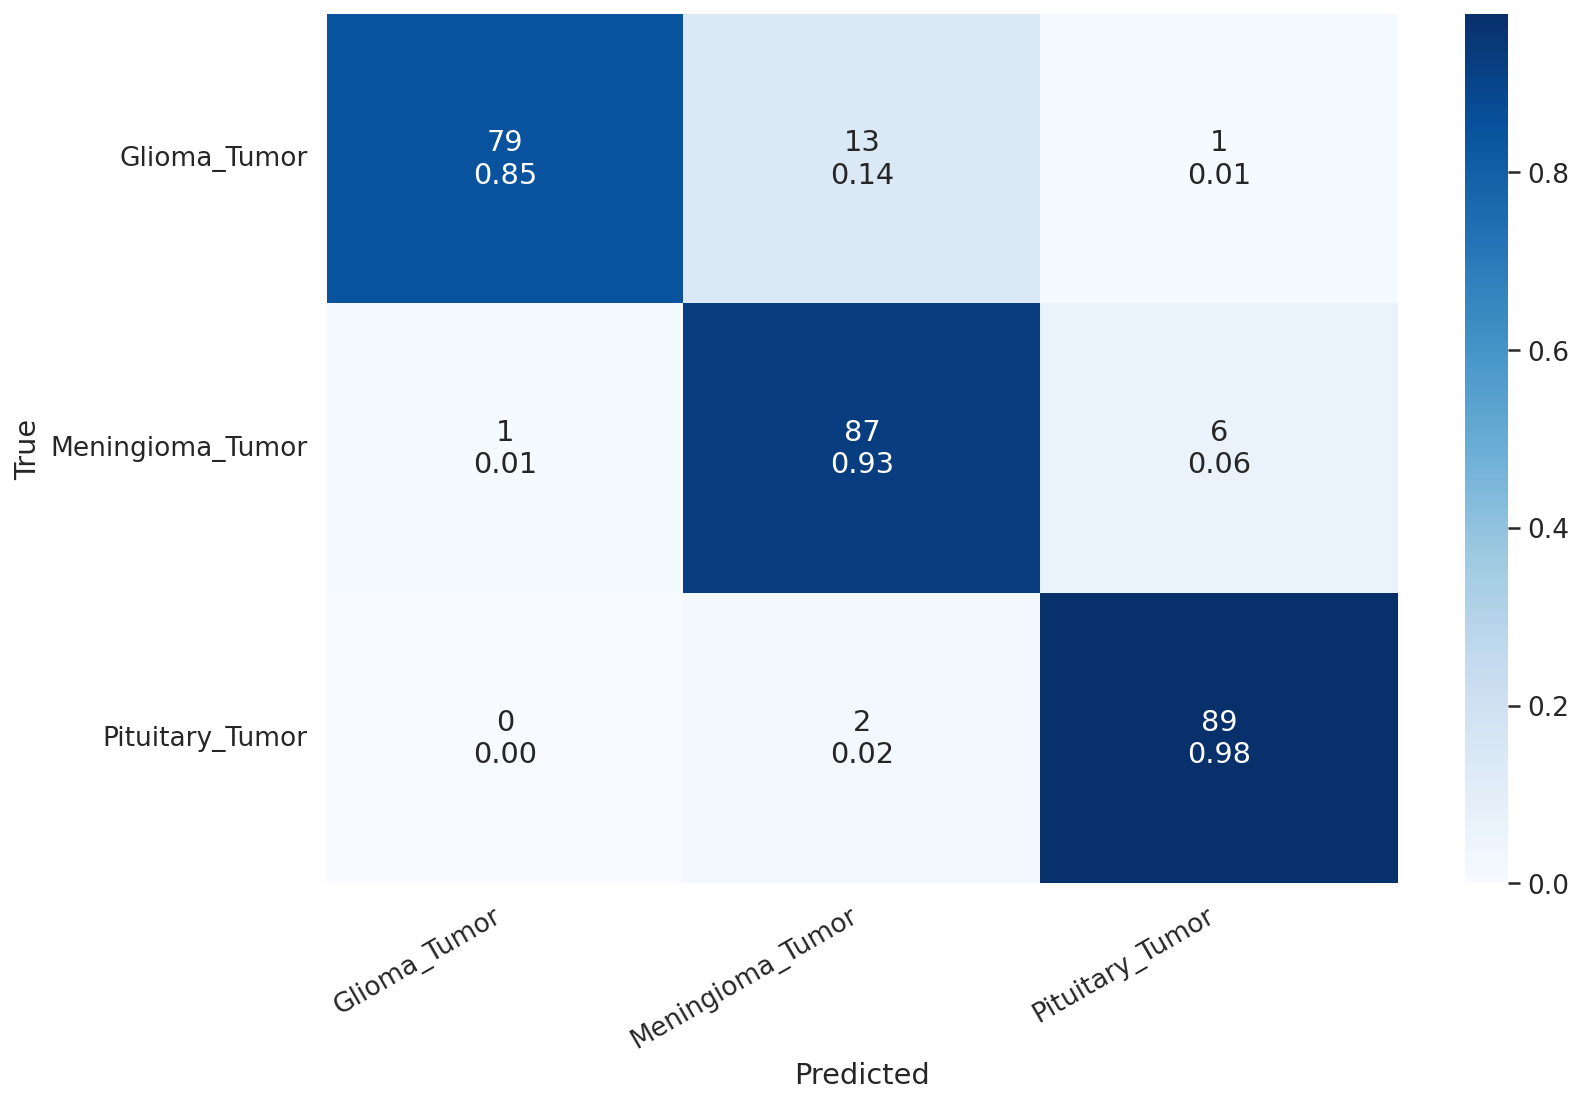

In [35]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

In [36]:
Tumor = '/content/Glioma.jpg'

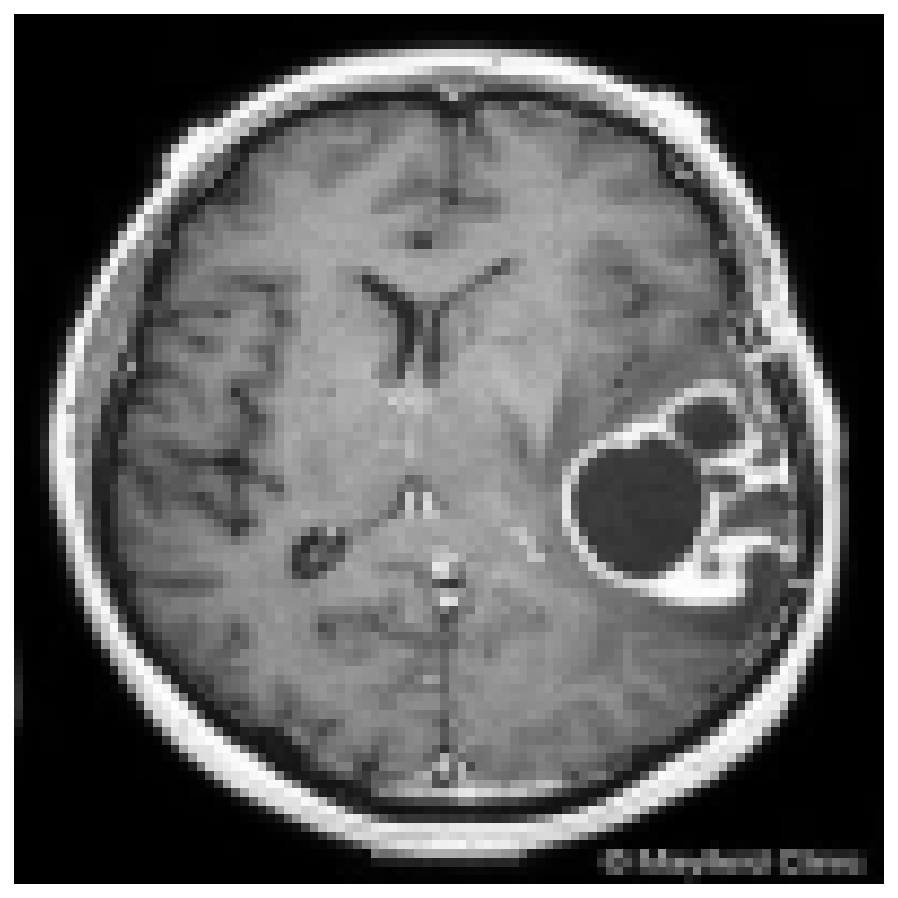

In [37]:
show_image(Tumor)

In [38]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred)
  return pred.detach().cpu().numpy().flatten()

In [39]:
pred = predict_proba(model, Tumor)
pred

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


array([0.21194157, 0.57611686, 0.21194157], dtype=float32)

In [40]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

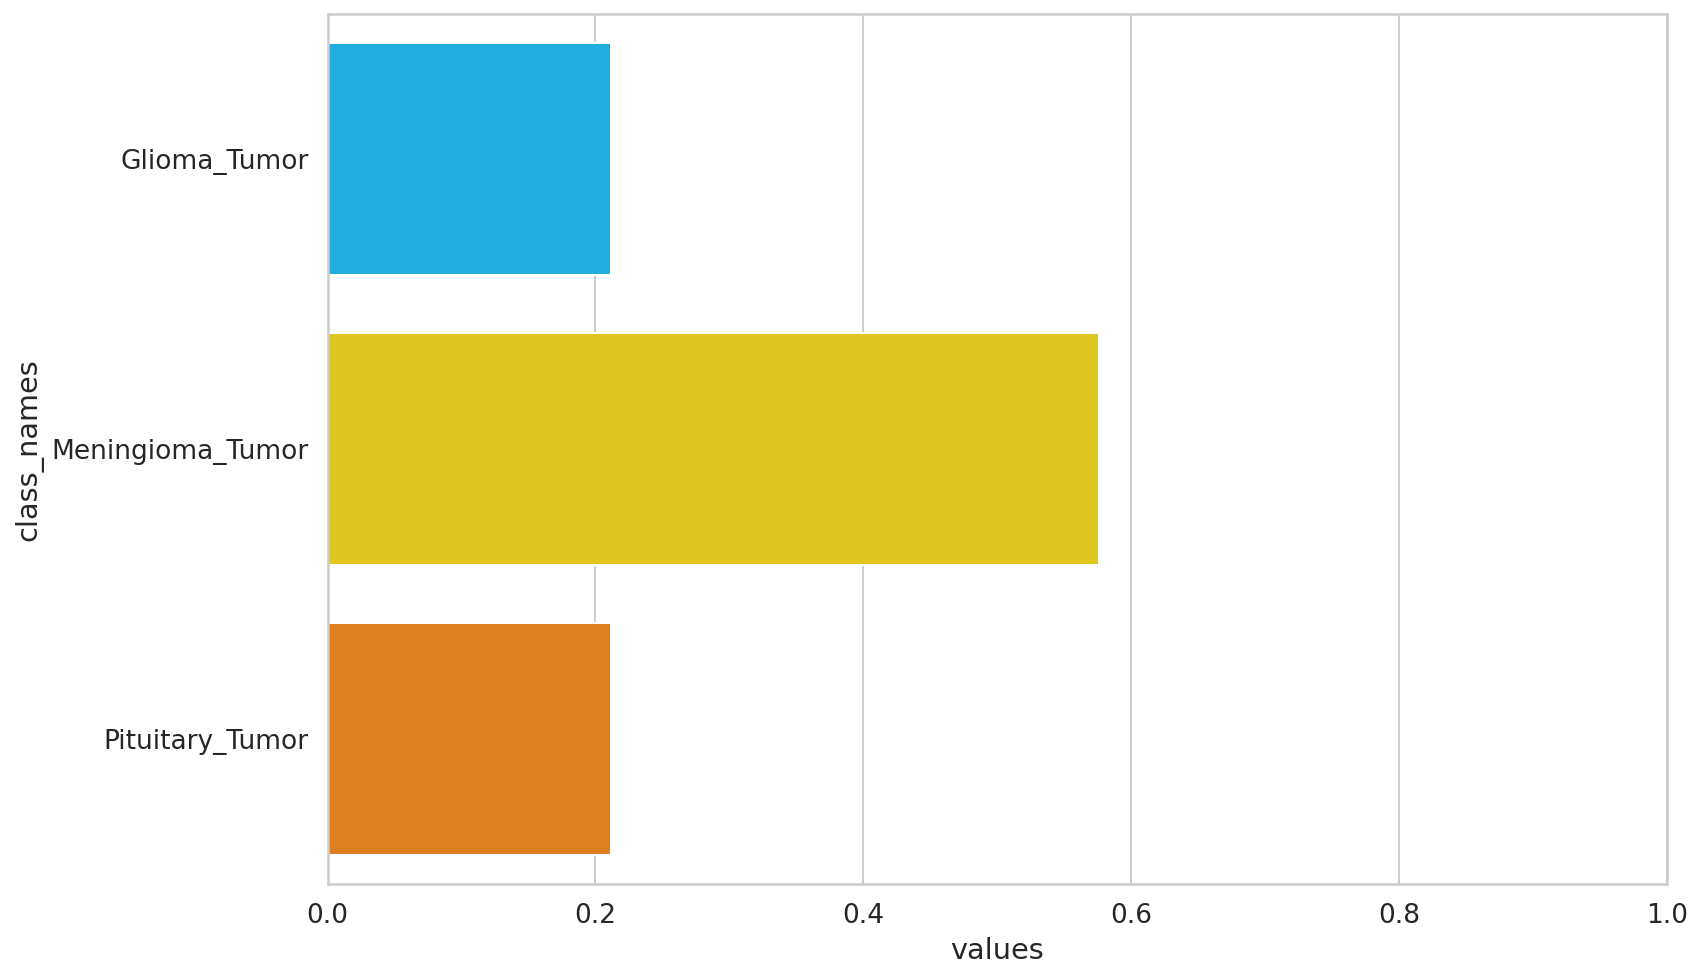

In [41]:
show_prediction_confidence(pred, class_names)

In [42]:
Tumor2 = '/content/Meningioma.jpg'

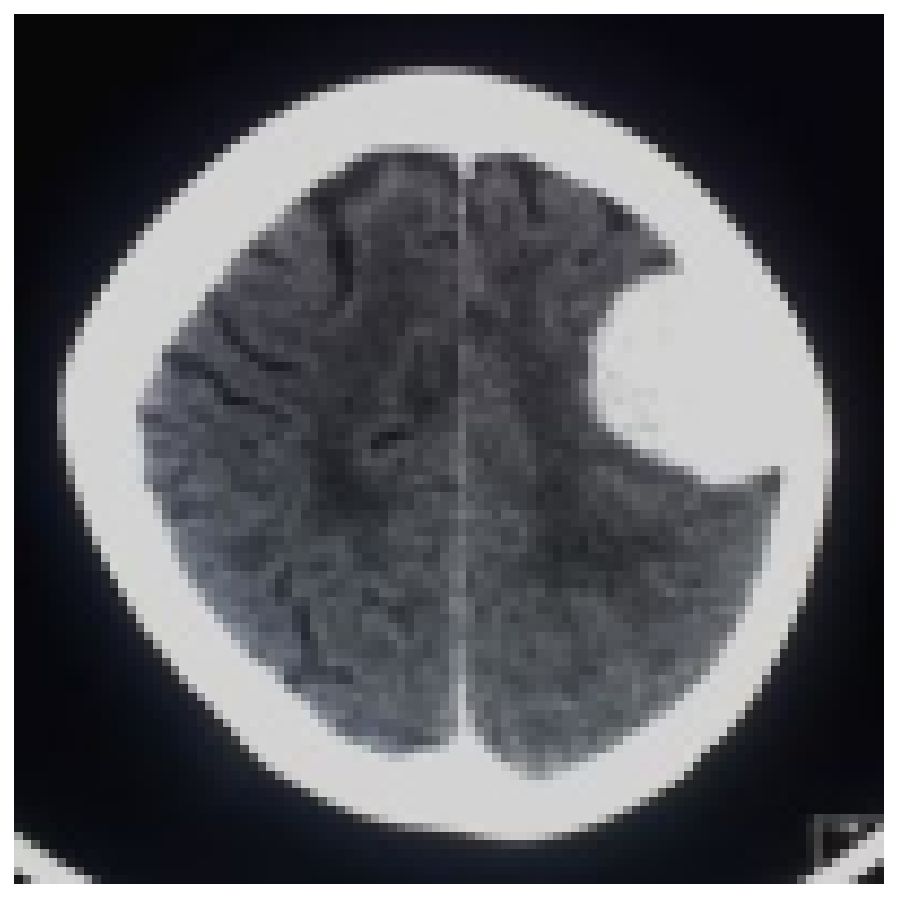

In [43]:
show_image(Tumor2)

In [44]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred)
  return pred.detach().cpu().numpy().flatten()

In [45]:
pred = predict_proba(model, Tumor2)
pred

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


array([0.21194157, 0.57611686, 0.21194157], dtype=float32)

In [46]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

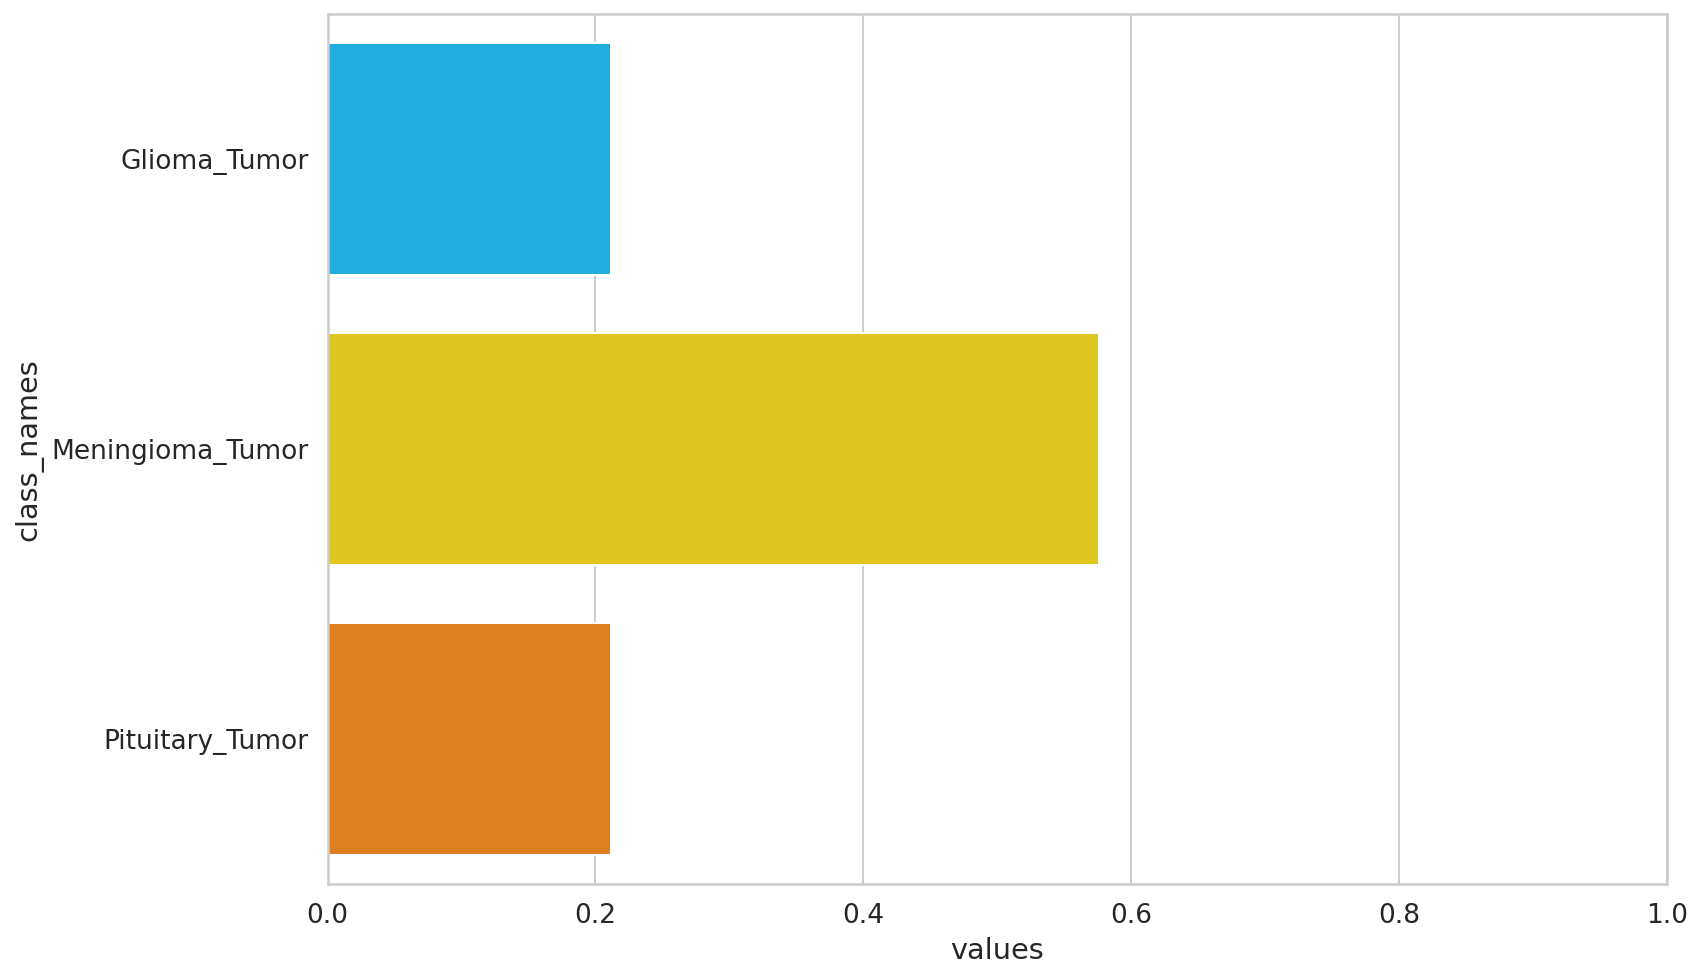

In [47]:
show_prediction_confidence(pred, class_names)

In [48]:
Tumor3 = '/content/Pituitary.jpg'

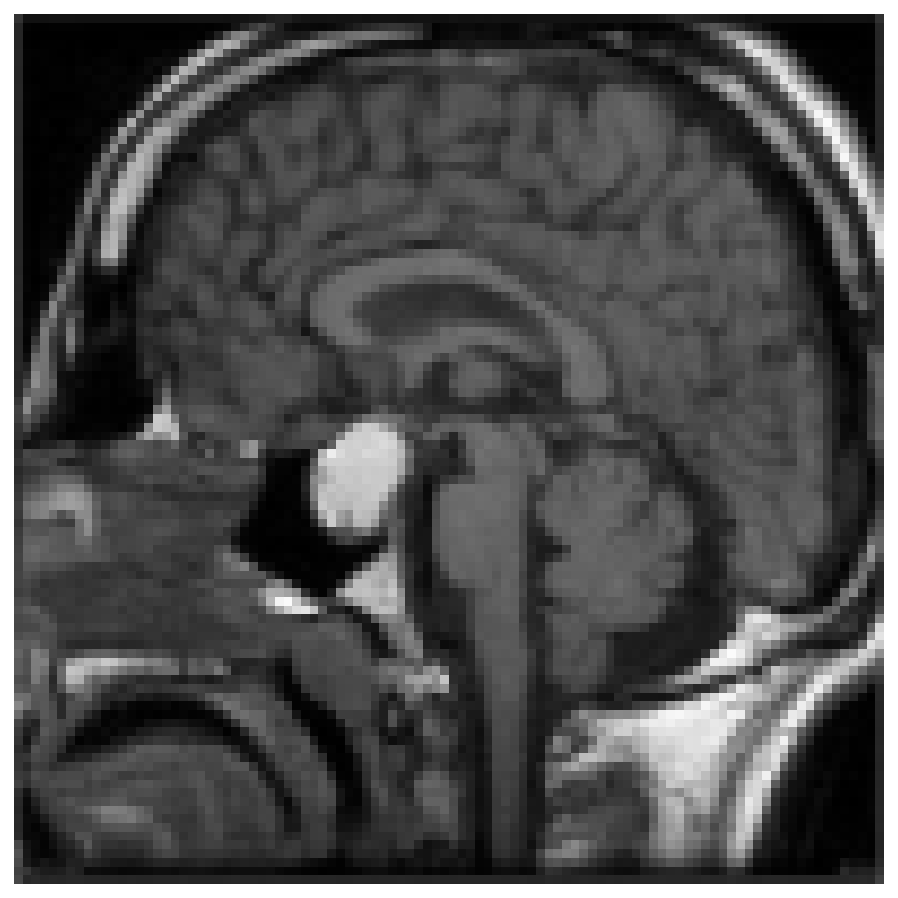

In [49]:
show_image(Tumor3)

In [50]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred)
  return pred.detach().cpu().numpy().flatten()

In [51]:
pred = predict_proba(model, Tumor3)
pred

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


array([0.21194218, 0.21194372, 0.5761142 ], dtype=float32)

In [52]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

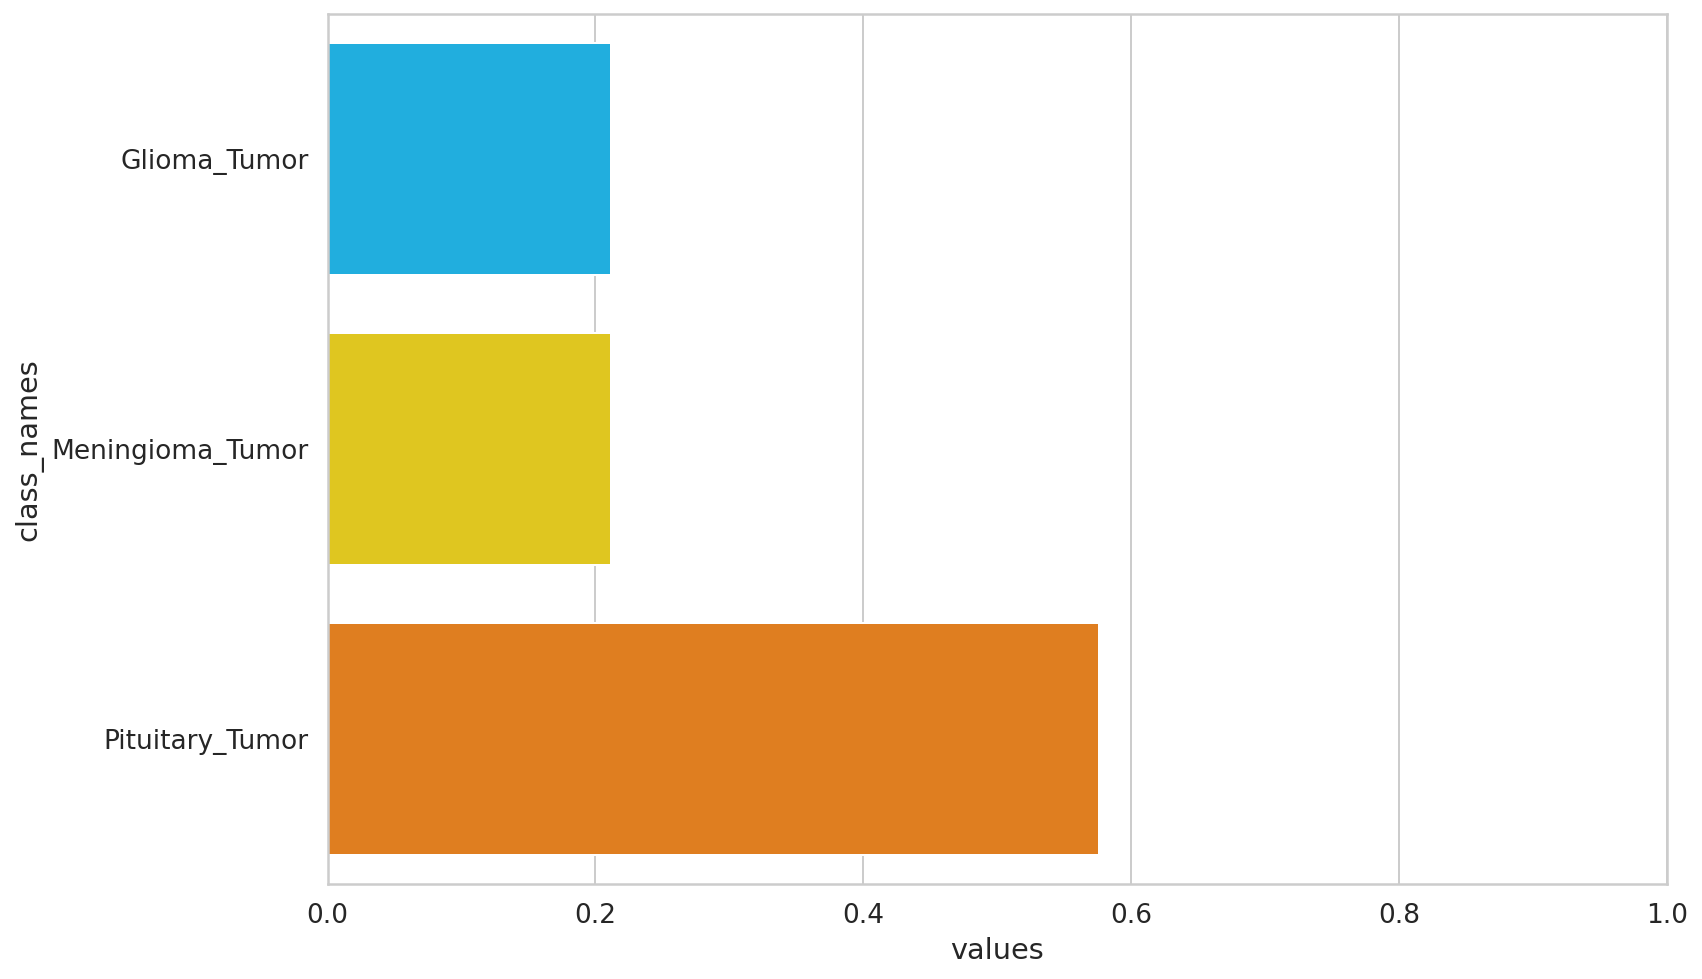

In [53]:
show_prediction_confidence(pred, class_names)

In [54]:
Tumor4 = '/content/Test 4.jpg'

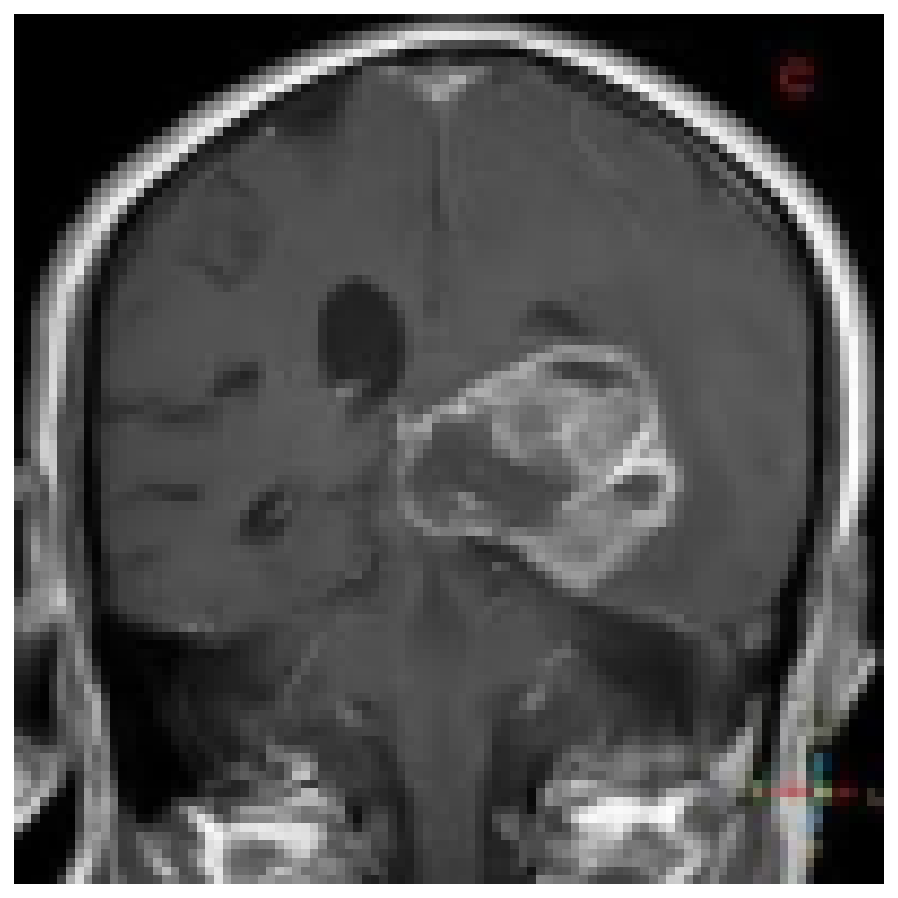

In [55]:
show_image(Tumor4)

In [56]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred)
  return pred.detach().cpu().numpy().flatten()

In [57]:
pred = predict_proba(model, Tumor4)
pred

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


array([0.57584596, 0.21214288, 0.21201113], dtype=float32)

In [58]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

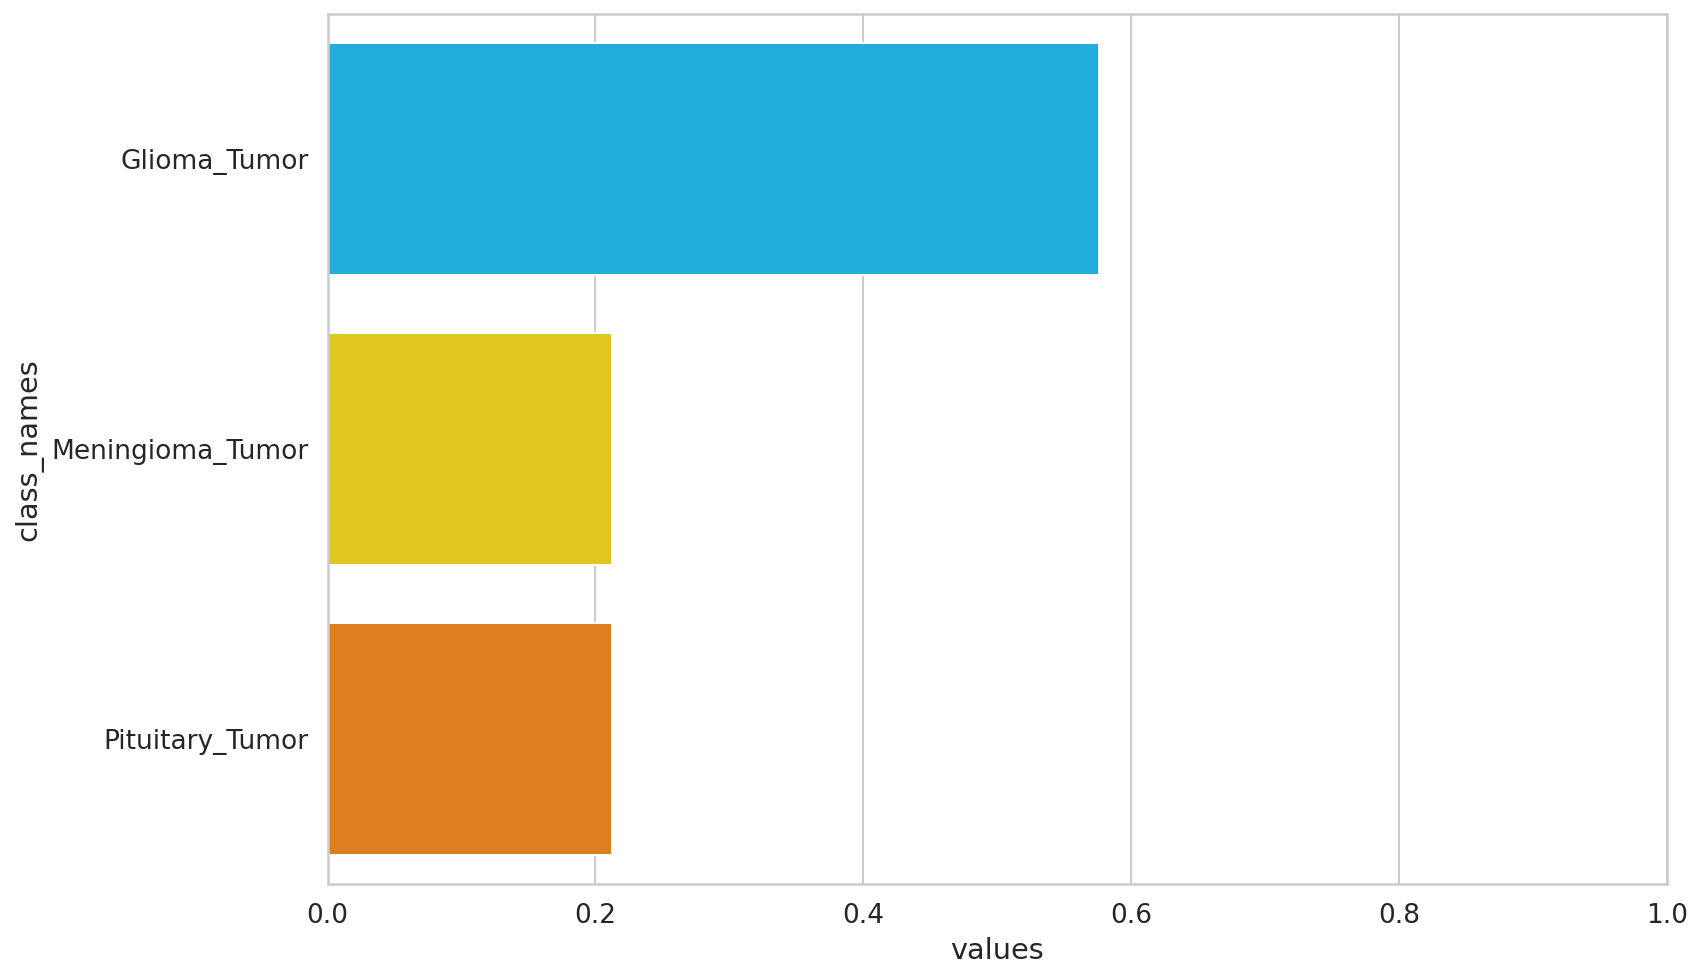

In [59]:
show_prediction_confidence(pred, class_names)